In [23]:
#!pip install gym
#!pip install pyyaml
#!pip install ipympl


#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

In [24]:
from env.maze_env import MazeEnv
import matplotlib.pyplot as plt
from utils.visualizations import animate_agent_path, plot_value_map
from utils.metrics import evaluate_policy, time_algorithm
import yaml
from utils.run_policy import run_policy
from agents_algo import dp_agent as dp
from agents_algo import monte_carlo_agent as mc
from agents_algo import td0_agent as td
from agents_algo import q_learning_agent as ql




In [25]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

env = MazeEnv()



### 1. Dynammic Programming (DP)

$$
V(s) \leftarrow \max_{a \in \mathcal{A}(s)} \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma V(s') \right]
$$


where the transition function is known and each state is known, thus:
$$ P(s' \mid s, a) = 1 $$ 
Meaning we know the probability in each state, what will be the probability for the next state.

[DP] gamma=0.9, theta=0.0001 (type: <class 'float'>)
 Convergence Iterations: 10
 Runtime: 0.0181 seconds
 Average Reward: 0.920


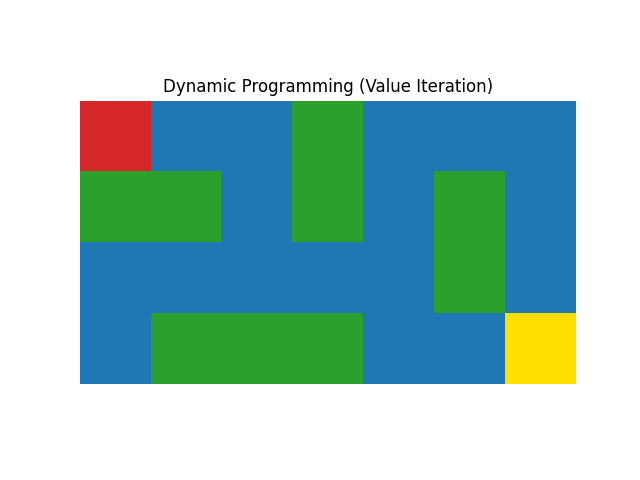

In [26]:
# --- Run DP and track time ---
(result, runtime) = time_algorithm(lambda: dp.value_iteration(env))
policy, value_table, iterations = result

# --- Evaluate policy ---
avg_reward, reward_per_episode = evaluate_policy(env, policy)

# --- Print Metrics ---
print(f" Convergence Iterations: {iterations}")
print(f" Runtime: {runtime:.4f} seconds")
print(f" Average Reward: {avg_reward:.3f}")

# --- Visualize ---
path = run_policy(env, policy)
animate_agent_path(env, path, title="Dynamic Programming (Value Iteration)")


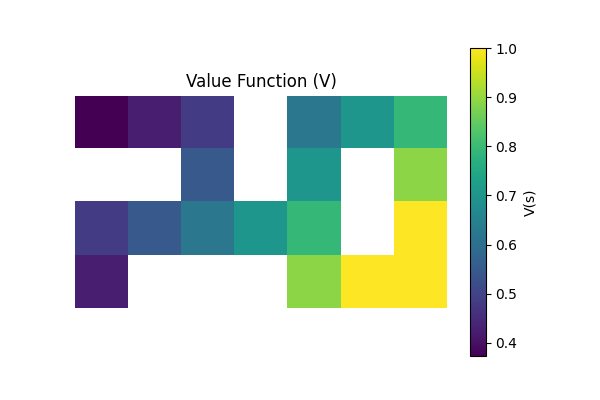

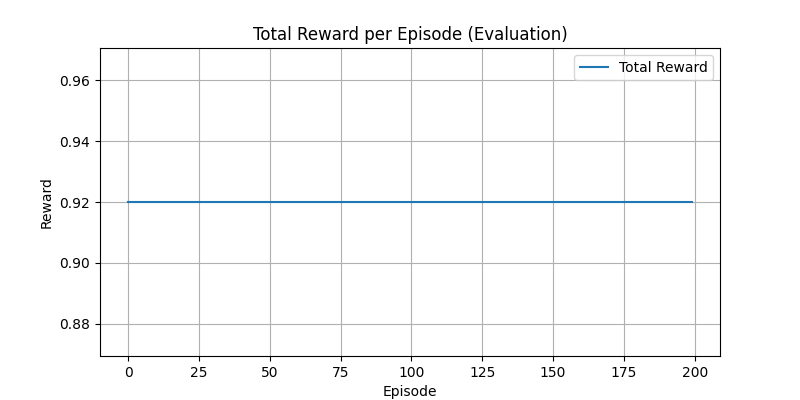

In [27]:
plot_value_map(env, value_table, title="Value Function (V)")

# --- Plot reward trend (even if static in DP) ---
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode, label="Total Reward")
plt.title("Total Reward per Episode (Evaluation)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

### Monte Carlo Control: Core Equations

We aim to learn the optimal action-value function \( Q(s, a) \) by averaging sampled returns \( G_t \) over episodes.

#### 1. Return:
The return \( G_t \) is the total discounted reward from time step \( t \) to the end of the episode:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots + \gamma^{T - t - 1} r_T = \sum_{k=0}^{T - t - 1} \gamma^k r_{t+k+1}
$$

#### 2. Q-value Update Rule:
Using **first-visit Monte Carlo**, we update the Q-value incrementally:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left( G_t - Q(s, a) \right)
$$

$ \alpha$ : learning rate  
$G_t$: return observed from time \( t \)  
$Q(s, a)$: estimate of expected return from taking action \( a \) in state \( s \)

#### 3. Policy (ε-greedy):
The policy is updated using an ε-greedy strategy over the Q-values:

$$
\pi(s) = 
\begin{cases}
\text{argmax}_a \, Q(s, a) & \text{with probability } 1 - \epsilon \\
\text{random action} & \text{with probability } \epsilon
\end{cases}
$$

This ensures exploration while still favoring actions with high estimated value.

#### Notes:
- Monte Carlo methods are model-free and require complete episodes.
- They converge as more episodes are sampled, averaging out the true expected return.


In [28]:

# --- Run Monte Carlo and track time ---
(result, runtime) = time_algorithm(lambda: mc.train_monte_carlo(env))
policy, value_table, q_table, reward_per_episode, convergence_ep = result

# --- Evaluate policy ---
avg_reward, _ = evaluate_policy(env, policy)

# --- Print Metrics ---
print(f"Converged at episode: {convergence_ep}")
print(f"Runtime: {runtime:.4f} seconds")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

# --- Visualize path ---
path = run_policy(env, policy)
#animate_agent_path(env, path, title="Monte Carlo Agent Path")


Converged at episode: 22
Runtime: 4.1180 seconds
Average Evaluation Reward: 0.920


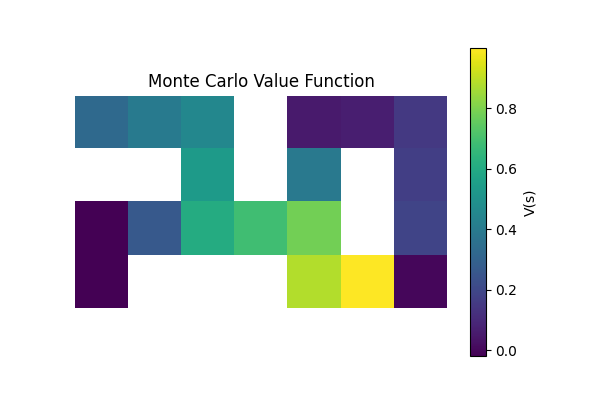

C:\Users\97254\AppData\Local\Temp\ipykernel_33084\176550688.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))


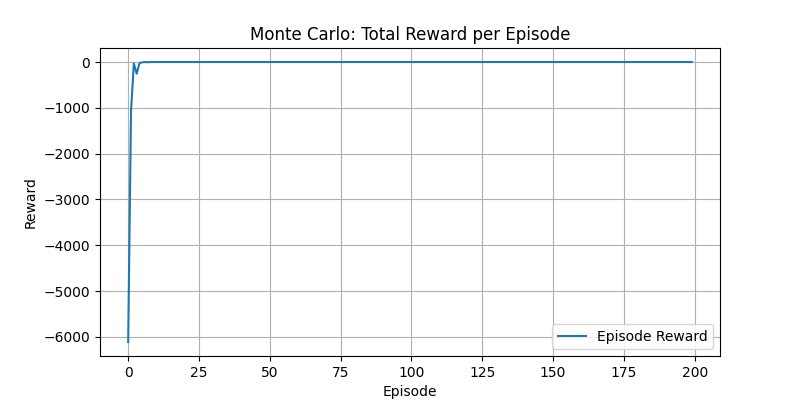

In [29]:
plot_value_map(env, value_table, title="Monte Carlo Value Function")

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode, label="Episode Reward")
plt.title("Monte Carlo: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


### 3. Temporal Difference Learning (TD(0))

Temporal Difference (TD) Learning is a model-free reinforcement learning method that updates the value of a state based on the reward received and the estimated value of the next state. It combines ideas from both Monte Carlo methods and Dynamic Programming.

#### TD(0) Update Rule

After taking action at time $t$, we observe reward $r_{t+1}$ and next state $s_{t+1}$.  
We update the value function $V(s)$ using the TD(0) rule:

$$
V(s_t) \leftarrow V(s_t) + \alpha \left( r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \right)
$$

####  Parameters:
- $\alpha$: Learning rate  
- $\gamma$: Discount factor  
- $r_{t+1}$: Reward received after taking action at $s_t$  
- $V(s_t)$: Current estimate of the value of state $s_t$  
- $V(s_{t+1})$: Estimated value of the next state  

####  TD Error

The quantity inside the update is called the **TD error**:

$$
\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)
$$

We use this to update the value function:

$$
V(s_t) \leftarrow V(s_t) + \alpha \cdot \delta_t
$$


In [30]:

# Train TD(0) value estimator
(V, reward_per_episode), runtime = time_algorithm(lambda: td.train_td0(env))

# Extract policy after learning V(s)
policy = td.extract_policy(env, V, gamma=0.9)

# Evaluate and visualize
avg_reward, _ = evaluate_policy(env, policy)
path = run_policy(env, policy)

print(f"Runtime: {runtime:.3f}s")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

#animate_agent_path(env, path, title="TD(0) Agent Path")


Runtime: 0.294s
Average Evaluation Reward: 0.920


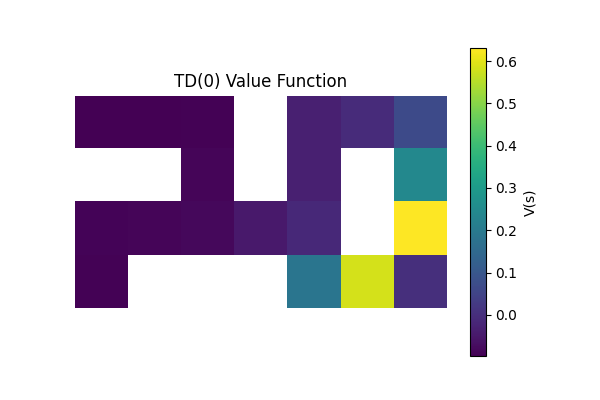

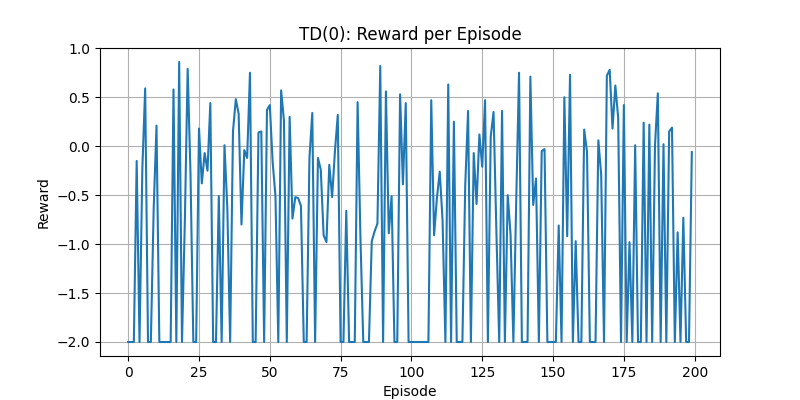

In [31]:
plot_value_map(env, V, title="TD(0) Value Function")

# Plot reward curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.title("TD(0): Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

### 4. Q-Learning

Q-Learning is an off-policy, model-free reinforcement learning algorithm that learns the optimal action-value function, denoted by $Q^*(s, a)$.

It uses the **Bellman optimality equation** to update the Q-values based on interaction with the environment.

####  Q-Learning Update Rule

At each time step $t$, after observing transition $(s_t, a_t, r_{t+1}, s_{t+1})$, the Q-value is updated as:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

- $\alpha$: Learning rate ($0 < \alpha \leq 1$)
- $\gamma$: Discount factor ($0 \leq \gamma \leq 1$)
- $r_{t+1}$: Reward received after taking action $a_t$ in state $s_t$
- $s_{t+1}$: Next state after action
- $\max_a Q(s_{t+1}, a)$: Estimated value of the best action in the next state (greedy choice)



####  ε-Greedy Policy for Exploration

To balance exploration and exploitation:

- With probability $\epsilon$, choose a **random** action
- With probability $1 - \epsilon$, choose:

$$
a = \arg\max_a Q(s, a)
$$

This encourages the agent to explore new actions while gradually favoring the best-known ones.

---

####  Goal of Q-Learning

By continually updating $Q(s, a)$ and acting $\epsilon$-greedily, the agent converges toward the **optimal action-value function** $Q^*(s, a)$:

$$
\pi^*(s) = \arg\max_a Q^*(s, a)
$$



In [32]:

# Run and time Q-learning
(result, runtime) = time_algorithm(lambda: ql.train_q_learning(env))
policy, value_table, q_table, reward_per_episode, convergence_ep = result

# Evaluate final policy
avg_reward, _ = evaluate_policy(env, policy)
path = run_policy(env, policy)

# Print metrics
print(f"Q-learning converged at episode: {convergence_ep}")
print(f"Runtime: {runtime:.4f} seconds")
print(f"Average Evaluation Reward: {avg_reward:.3f}")

# Visualize
#animate_agent_path(env, path, title="Q-learning Agent Path")


Q-learning converged at episode: 29
Runtime: 0.1947 seconds
Average Evaluation Reward: 0.920


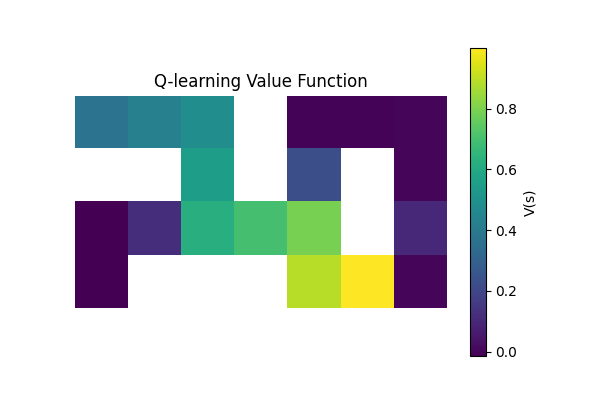

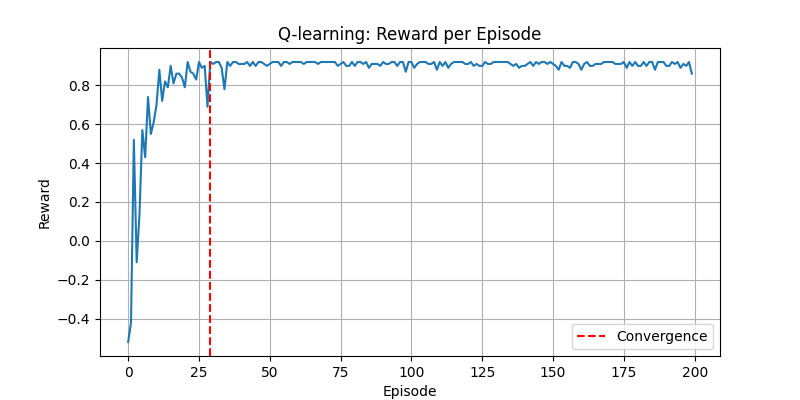

In [33]:
plot_value_map(env, value_table, title="Q-learning Value Function")

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(reward_per_episode)
plt.axvline(convergence_ep, color="red", linestyle="--", label="Convergence")
plt.title("Q-learning: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()